In [33]:
import torch
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights, mobilenet_v2, MobileNet_V2_Weights
from torch import nn
from torch import optim
from PIL import Image
import os
import sys
import re
import tqdm
import random 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import cv2
import imageio
from facenet_pytorch import MTCNN
from matplotlib.pyplot import imshow
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import gc
import cv2
import torch
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from facenet_pytorch import MTCNN
from ultralytics import YOLO
from concurrent.futures import ThreadPoolExecutor
# Import datasets class buat dataloader
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
# from utils import DataPreprocessing, TripletDataset, DatasetClassification, class_to_image_path, extract_class

In [5]:
import os
import re
import gc
import math
import torch
from PIL import Image, ImageOps
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from ultralytics import YOLO
from facenet_pytorch import MTCNN

class FaceCropper:
    def __init__(self, mtcnn_device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.mtcnn = MTCNN(keep_all=False, device=mtcnn_device)
        self.yolo_fallback = YOLO(
            r"D:\Models\huggingface\hub\models--arnabdhar--YOLOv8-Face-Detection\snapshots\52fa54977207fa4f021de949b515fb19dcab4488\model.pt"
        )

    def extract_class(self, txt):
        raw_class = re.split(r"[-_.]", txt, 2)[0:2]
        complete_class = raw_class[0] + "_" + raw_class[1]
        complete_class = re.sub(r'[\d\s]+$', '', complete_class)
        return complete_class
    
    def auto_rotate_image(self, image):
        """Rotate image using MTCNN landmarks"""
        _, _, landmarks = self.mtcnn.detect(image, landmarks=True)
        if landmarks is not None:
            left_eye, right_eye = landmarks[0][:2]
            dx, dy = right_eye[0] - left_eye[0], right_eye[1] - left_eye[1]
            angle = math.degrees(math.atan2(dy, dx))
            image = image.rotate(-angle, expand=True)
        return image
    
    def crop_face(self, image_path):
        try:
            image = Image.open(image_path)
            image = ImageOps.exif_transpose(image)
            image = self.auto_rotate_image(image)
    
            # First try MTCNN
            boxes, _ = self.mtcnn.detect(image)
            if boxes is not None and len(boxes) > 0:
                box = boxes[0]
            else:
                # Fall back to YOLO
                results = self.yolo_fallback(image_path)
                if results and len(results[0].boxes.xyxy) > 0:
                    box = results[0].boxes.xyxy[0].cpu().numpy()
                else:
                    return None
    
            left, top, right, bottom = map(int, box)
            return image.crop((left, top, right, bottom))
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")
            return None
    
    def process_folder(self, input_dir, output_dir, batch_size=32, max_workers=8):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
        
            def process_file(fname):
                path = os.path.join(input_dir, fname)
                cropped = self.crop_face(path)
                if cropped:
                    class_name = self.extract_class(fname)
                    class_dir = os.path.join(output_dir, class_name)
                    os.makedirs(class_dir, exist_ok=True)  # Create class subfolder safely
                    save_path = os.path.join(class_dir, fname)  # keep original filename
                    # If file exists, append counter
                    counter = 1
                    base, ext = os.path.splitext(save_path)
                    while os.path.exists(save_path):
                        save_path = f"{base}_{counter}{ext}"
                        counter += 1
                    cropped.save(save_path)
        
            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                list(tqdm(executor.map(process_file, batch_files), total=len(batch_files)))
        
            # Clean memory
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()




In [ ]:
# Initialize cropper
cropper = FaceCropper()

# --- Train paths ---
train_input = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train"
train_output = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped MTCNN fix"

print("🟢 Starting TRAIN image cropping...")
cropper.process_folder(train_input, train_output)

# --- Test paths ---
test_input = train_input.replace("Train", "Test")
test_output = train_output.replace("Train", "Test")

print("\n🟣 Starting TEST image cropping...")
cropper.process_folder(test_input, test_output)

print("\n✅ All done! Cropped images saved successfully.")

🟢 Starting TRAIN image cropping...


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.01it/s]



🟣 Starting TEST image cropping...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.96it/s]



✅ All done! Cropped images saved successfully.


In [ ]:
# Initialize MediaPipe cropper
cropper = FaceCropperMP()

# --- Train paths ---
train_input = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train"
train_output = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped MP"

print("🟢 Starting TRAIN image cropping...")
cropper.process_folder(train_input, train_output)

# --- Test paths ---
test_input = train_input.replace("Train", "Test")
test_output = train_output.replace("Train", "Test")

print("\n🟣 Starting TEST image cropping...")
cropper.process_folder(test_input, test_output)

print("\n✅ All done! Cropped images saved successfully.")


In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Paths
# train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped MTCNN fix"
# test_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped MTCNN fix"
train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped OLD classed"
test_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped OLD classed"

# Transformations
# MobileNet usually expects 224x224 input and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders (fast with multiple workers)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# import os
# import gc
# import math
# from PIL import Image, ImageOps
# from concurrent.futures import ThreadPoolExecutor
# import mediapipe as mp
# import numpy as np
# from tqdm import tqdm

# mp_face_mesh = mp.solutions.face_mesh

# class FaceCropperMP:
#     def __init__(self):
#         self.face_mesh = mp_face_mesh.FaceMesh(
#             static_image_mode=True,
#             max_num_faces=1,
#             refine_landmarks=True,
#             min_detection_confidence=0.5
#         )

#     def extract_class(self, filename):
#         parts = filename.split('_')[:2]
#         class_name = '_'.join(parts)
#         return ''.join([c for c in class_name if not c.isdigit()]).strip()

#     def auto_rotate_and_crop(self, image):
#         try:
#             img_rgb = image.convert("RGB")
#             results = self.face_mesh.process(np.array(img_rgb))

#             if not results.multi_face_landmarks:
#                 return None

#             landmarks = results.multi_face_landmarks[0].landmark
#             # approximate eyes
#             left_eye = landmarks[33]
#             right_eye = landmarks[263]

#             width, height = image.size
#             lx, ly = int(left_eye.x * width), int(left_eye.y * height)
#             rx, ry = int(right_eye.x * width), int(right_eye.y * height)

#             # rotation angle
#             dx, dy = rx - lx, ry - ly
#             angle = math.degrees(math.atan2(dy, dx))
#             image = image.rotate(-angle, expand=True)

#             # crop bounding box around landmarks
#             xs = [int(lm.x * width) for lm in landmarks]
#             ys = [int(lm.y * height) for lm in landmarks]
#             left, top, right, bottom = min(xs), min(ys), max(xs), max(ys)

#             return image.crop((left, top, right, bottom))

#         except Exception as e:
#             print(f"Failed to process image: {e}")
#             return None

#     def process_folder(self, input_dir, output_dir, batch_size=32, max_workers=8):
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)

#         image_files = [f for f in os.listdir(input_dir)
#                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

#         for i in range(0, len(image_files), batch_size):
#             batch_files = image_files[i:i + batch_size]

#             def process_file(fname):
#                 path = os.path.join(input_dir, fname)
#                 try:
#                     image = Image.open(path)
#                     image = ImageOps.exif_transpose(image)
#                     cropped = self.auto_rotate_and_crop(image)
#                     if cropped:
#                         class_name = self.extract_class(fname)
#                         class_dir = os.path.join(output_dir, class_name)
#                         os.makedirs(class_dir, exist_ok=True)
#                         save_path = os.path.join(class_dir, fname)
#                         counter = 1
#                         base, ext = os.path.splitext(save_path)
#                         while os.path.exists(save_path):
#                             save_path = f"{base}_{counter}{ext}"
#                             counter += 1
#                         cropped.save(save_path)
#                     else:
#                         print(f"Skipped: {fname}")
#                 except Exception as e:
#                     print(f"Failed: {fname}, {e}")

#             with ThreadPoolExecutor(max_workers=max_workers) as executor:
#                 list(tqdm(executor.map(process_file, batch_files), total=len(batch_files)))

#             gc.collect()

# # Example usage
# # cropper = FaceCropperMP()
# # cropper.process_folder("train_images", "train_cropped")
# # cropper.process_folder("test_images", "test_cropped")


In [46]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return nn.CrossEntropyLoss()(logits, labels)
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale
    
class SoftmaxLoss(nn.Module):
    def __init__(self, num_classes, embedding_size):
        """
        Regular softmax loss (1 fc layer without bias + CrossEntropyLoss)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        logits = F.linear(embeddings, self.W)
        return nn.CrossEntropyLoss()(logits, labels)

In [ ]:

class MobilenetEmbedding(nn.Module):
    def __init__(self, embedding_size=128, weights=None):
        super().__init__()
        self.mobilenet = mobilenet_v3_large(weights=weights)
        # self.mobilenet = mobilenet_v2(weights=weights) 
        self.mobilenet.classifier[3] = nn.Linear(1280, embedding_size)
        if weights is not None:
            for param in self.mobilenet.parameters():
                param.requires_grad = False
            for param in self.mobilenet.classifier[3].parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.mobilenet(x)
        x = F.normalize(x, p=2, dim=1)
        return x

class MobilenetEmbedding(nn.Module):
    def __init__(self, embedding_size=128, weights=None):
        super().__init__()
        # self.mobilenet = mobilenet_v3_large(weights=weights)
        self.mobilenet = mobilenet_v2(weights=weights) 
        self.mobilenet.classifier[1] = nn.Linear(1280, embedding_size)
        if weights is not None:
            for param in self.mobilenet.parameters():
                param.requires_grad = False
            for param in self.mobilenet.classifier[1].parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.mobilenet(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [53]:

model = MobilenetEmbedding(
    embedding_size=128,
    weights=MobileNet_V2_Weights.IMAGENET1K_V1
).to(device)
for name, param in model.named_parameters():
    print(f"Name: {name}, Requires Grad: {param.requires_grad}, Shape: {param.shape}")


Name: mobilenet.features.0.0.weight, Requires Grad: True, Shape: torch.Size([32, 3, 3, 3])
Name: mobilenet.features.0.1.weight, Requires Grad: True, Shape: torch.Size([32])
Name: mobilenet.features.0.1.bias, Requires Grad: True, Shape: torch.Size([32])
Name: mobilenet.features.1.conv.0.0.weight, Requires Grad: True, Shape: torch.Size([32, 1, 3, 3])
Name: mobilenet.features.1.conv.0.1.weight, Requires Grad: True, Shape: torch.Size([32])
Name: mobilenet.features.1.conv.0.1.bias, Requires Grad: True, Shape: torch.Size([32])
Name: mobilenet.features.1.conv.1.weight, Requires Grad: True, Shape: torch.Size([16, 32, 1, 1])
Name: mobilenet.features.1.conv.2.weight, Requires Grad: True, Shape: torch.Size([16])
Name: mobilenet.features.1.conv.2.bias, Requires Grad: True, Shape: torch.Size([16])
Name: mobilenet.features.2.conv.0.0.weight, Requires Grad: True, Shape: torch.Size([96, 16, 1, 1])
Name: mobilenet.features.2.conv.0.1.weight, Requires Grad: True, Shape: torch.Size([96])
Name: mobilenet.

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import MobileNet_V2_Weights
from tqdm import tqdm

# --- Paths ---
# train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped OLD classed"
# test_dir  = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped OLD classed"
train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped MTCNN fix"
test_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped MTCNN fix"

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# --- Dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# --- Model ---
model = MobilenetEmbedding(
    embedding_size=128,
    weights=MobileNet_V2_Weights.IMAGENET1K_V1
).to(device)

# --- Loss & Optimizer ---
criterion = ArcFaceLoss(
    num_classes=54,
    embedding_size=128,
    margin=0.3,
    scale=30.0
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1.5e-4, weight_decay=5e-5)

# --- Training Loop ---
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        embeddings = model(imgs)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            embeddings = model(imgs)
            loss = criterion(embeddings, labels)
            test_loss += loss.item() * imgs.size(0)

    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


Epoch 1/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch 1 | Train Loss: 11.7449 | Test Loss: 9.6676


Epoch 2/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 2 | Train Loss: 4.7450 | Test Loss: 4.4552


Epoch 3/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 3 | Train Loss: 1.3139 | Test Loss: 2.3400


Epoch 4/15 - Validation: 100%|██████████| 27/27 [00:21<00:00,  1.29it/s]


Epoch 4 | Train Loss: 0.4670 | Test Loss: 1.7301


Epoch 5/15 - Validation: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Epoch 5 | Train Loss: 0.2463 | Test Loss: 0.9994


Epoch 6/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


Epoch 6 | Train Loss: 0.1338 | Test Loss: 1.0112


Epoch 7/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


Epoch 7 | Train Loss: 0.1177 | Test Loss: 0.9900


Epoch 8/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 8 | Train Loss: 0.0753 | Test Loss: 0.7363


Epoch 9/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 9 | Train Loss: 0.0433 | Test Loss: 0.8567


Epoch 10/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Epoch 10 | Train Loss: 0.0473 | Test Loss: 0.7728


Epoch 11/15 - Validation: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


Epoch 11 | Train Loss: 0.0675 | Test Loss: 0.8536


Epoch 12/15 - Validation: 100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


Epoch 12 | Train Loss: 0.0407 | Test Loss: 0.7423


Epoch 13/15 - Training:  44%|████▍     | 18/41 [00:17<00:22,  1.00it/s]


KeyboardInterrupt: 

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import MobileNet_V2_Weights
from tqdm import tqdm

# --- Paths ---
# train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped OLD classed"
# test_dir  = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped OLD classed"
train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped MTCNN fix"
test_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped MTCNN fix"

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# --- Dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# --- Model ---
model = MobilenetEmbedding(
    embedding_size=128,
    weights=MobileNet_V2_Weights.IMAGENET1K_V1
).to(device)

# --- Loss & Optimizer ---
criterion = ArcFaceLoss(
    num_classes=54,
    embedding_size=128,
    margin=0.3,
    scale=30.0
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1.5e-4, weight_decay=5e-5)

# --- Training Loop ---
num_epochs = 15
early_stop_patience = 5  # stop if test loss hasn't improved for 5 epochs
best_loss = float('inf')
epochs_no_improve = 0
stopped_early = False
best_model_state = None

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        embeddings = model(imgs)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            embeddings = model(imgs)
            loss = criterion(embeddings, labels)
            test_loss += loss.item() * imgs.size(0)

    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # --- Early Stopping Check ---
    if test_loss < best_loss - 1e-5:  # small threshold for improvement
        best_loss = test_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        stopped_early = True
        break

# Optionally, load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
# Save the best model after training / early stopping
save_path = r"D:\Code\Kuliah\Deep Learning\tugas_4\models\mobilenetv2_arcface_best.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Best model saved to: {save_path}")

Epoch 1/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 1 | Train Loss: 11.1741 | Test Loss: 9.3295


Epoch 2/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 2 | Train Loss: 4.1952 | Test Loss: 4.6143


Epoch 3/15 - Validation: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Epoch 3 | Train Loss: 1.1857 | Test Loss: 2.0590


Epoch 4/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch 4 | Train Loss: 0.5585 | Test Loss: 1.4975


Epoch 5/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]


Epoch 5 | Train Loss: 0.2898 | Test Loss: 1.0580


Epoch 6/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 6 | Train Loss: 0.1331 | Test Loss: 0.9354


Epoch 7/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 7 | Train Loss: 0.0738 | Test Loss: 0.8290


Epoch 8/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 8 | Train Loss: 0.0624 | Test Loss: 0.8171


Epoch 9/15 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Epoch 9 | Train Loss: 0.0569 | Test Loss: 0.7826


Epoch 10/15 - Validation: 100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Epoch 10 | Train Loss: 0.0516 | Test Loss: 0.6688


Epoch 11/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


Epoch 11 | Train Loss: 0.0588 | Test Loss: 0.8207


Epoch 12/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 12 | Train Loss: 0.0553 | Test Loss: 0.6495


Epoch 13/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


Epoch 13 | Train Loss: 0.0307 | Test Loss: 0.7215


Epoch 14/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 14 | Train Loss: 0.0381 | Test Loss: 0.7199


Epoch 15/15 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


Epoch 15 | Train Loss: 0.0538 | Test Loss: 0.7997
✅ Best model saved to: D:\Code\Kuliah\Deep Learning\tugas_4\models\mobilenetv2_arcface_best.pth


In [85]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import MobileNet_V2_Weights
from tqdm import tqdm

# --- Paths ---
# train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped OLD classed"
# test_dir  = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped OLD classed"
train_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Train Cropped MTCNN fix"
test_dir = r"D:\Code\Kuliah\Deep Learning\tugas_4\data\Dataset Sistem Presensi Wajah V2.0\Data Test Cropped MTCNN fix"

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.9,1.1), shear=5),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# --- Dataloaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# --- Model ---
model = MobilenetEmbedding(
    embedding_size=128,
    weights=MobileNet_V2_Weights.IMAGENET1K_V1
).to(device)

# --- Loss & Optimizer ---
criterion = ArcFaceLoss(
    num_classes=54,
    embedding_size=128,
    margin=0.5,   # standard margin; increases angular separation
    scale=30.0    # keep the same
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1.5e-4, weight_decay=5e-5)

# --- Training Loop ---
num_epochs = 50
early_stop_patience = 5  # stop if test loss hasn't improved for 5 epochs
best_loss = float('inf')
epochs_no_improve = 0
stopped_early = False
best_model_state = None

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        embeddings = model(imgs)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            embeddings = model(imgs)
            loss = criterion(embeddings, labels)
            test_loss += loss.item() * imgs.size(0)

    test_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # --- Early Stopping Check ---
    if test_loss < best_loss - 1e-5:  # small threshold for improvement
        best_loss = test_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        stopped_early = True
        break

# Optionally, load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
# Save the best model after training / early stopping
save_path = r"D:\Code\Kuliah\Deep Learning\tugas_4\models\mobilenetv2_arcface_diffmargin_moreagument_best.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Best model saved to: {save_path}")

Epoch 1/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 1 | Train Loss: 17.7598 | Test Loss: 16.6339


Epoch 2/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]


Epoch 2 | Train Loss: 13.3814 | Test Loss: 13.4777


Epoch 3/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


Epoch 3 | Train Loss: 7.8086 | Test Loss: 9.1582


Epoch 4/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 4 | Train Loss: 3.9763 | Test Loss: 6.5900


Epoch 5/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s]


Epoch 5 | Train Loss: 2.0972 | Test Loss: 4.3144


Epoch 6/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 6 | Train Loss: 1.1835 | Test Loss: 3.5472


Epoch 7/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 7 | Train Loss: 0.8025 | Test Loss: 2.9115


Epoch 8/50 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


Epoch 8 | Train Loss: 0.5074 | Test Loss: 2.6179


Epoch 9/50 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 9 | Train Loss: 0.4743 | Test Loss: 1.8817


Epoch 10/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s]


Epoch 10 | Train Loss: 0.2710 | Test Loss: 1.9759


Epoch 11/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


Epoch 11 | Train Loss: 0.2281 | Test Loss: 1.8514


Epoch 12/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


Epoch 12 | Train Loss: 0.1962 | Test Loss: 2.1070


Epoch 13/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]


Epoch 13 | Train Loss: 0.1630 | Test Loss: 1.5759


Epoch 14/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.42it/s]


Epoch 14 | Train Loss: 0.1556 | Test Loss: 1.4085


Epoch 15/50 - Validation: 100%|██████████| 27/27 [00:18<00:00,  1.42it/s]


Epoch 15 | Train Loss: 0.1303 | Test Loss: 1.2468


Epoch 16/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.41it/s]


Epoch 16 | Train Loss: 0.0919 | Test Loss: 1.3975


Epoch 17/50 - Validation: 100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


Epoch 17 | Train Loss: 0.1293 | Test Loss: 1.3615


Epoch 18/50 - Validation: 100%|██████████| 27/27 [00:18<00:00,  1.42it/s]


Epoch 18 | Train Loss: 0.1414 | Test Loss: 1.3279


Epoch 19/50 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


Epoch 19 | Train Loss: 0.1005 | Test Loss: 1.4541


Epoch 20/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


Epoch 20 | Train Loss: 0.0809 | Test Loss: 1.1434


Epoch 21/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


Epoch 21 | Train Loss: 0.0490 | Test Loss: 1.3326


Epoch 22/50 - Validation: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


Epoch 22 | Train Loss: 0.0544 | Test Loss: 1.5540


Epoch 23/50 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Epoch 23 | Train Loss: 0.0875 | Test Loss: 1.2250


Epoch 24/50 - Validation: 100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Epoch 24 | Train Loss: 0.1289 | Test Loss: 1.3865


Epoch 25/50 - Validation: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]

Epoch 25 | Train Loss: 0.0814 | Test Loss: 1.2364
Early stopping triggered after 25 epochs.
✅ Best model saved to: D:\Code\Kuliah\Deep Learning\tugas_4\models\mobilenetv2_arcface_diffmargin_moreagument_best.pth


In [86]:
import torch
import numpy as np

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model ---
model = MobilenetEmbedding(embedding_size=128).to(device)
# model.load_state_dict(torch.load(r"D:\Code\Kuliah\Deep Learning\tugas_4\models\mobilenetv2_arcface_best.pth", weights_only=True))
model.load_state_dict(torch.load(r"D:\Code\Kuliah\Deep Learning\tugas_4\models\mobilenetv2_arcface_diffmargin_moreagument_best.pth", weights_only=True))
model.eval()

# --- Extract train embeddings ---
X_train = []
y_train = []

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        emb = model(imgs)
        X_train.append(emb.cpu().numpy())
        y_train.append(labels.numpy())

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

# --- Extract test embeddings ---
X_test = []
y_test = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        emb = model(imgs)
        X_test.append(emb.cpu().numpy())
        y_test.append(labels.numpy())

X_test = np.vstack(X_test)
y_test = np.hstack(y_test)

# --- Build class prototypes ---
classes = np.unique(y_train)
# Build prototypes with class indices aligned to ImageFolder
prototypes = {}
for idx, cls in enumerate(train_dataset.classes):  # use ImageFolder.classes
    class_idx = train_dataset.class_to_idx[cls]
    prototypes[class_idx] = X_train[y_train == class_idx].mean(axis=0)
    prototypes[class_idx] /= np.linalg.norm(prototypes[class_idx])

# --- Prediction function ---
def predict_embedding(embedding, prototypes, threshold=0.5):
    embedding = embedding / np.linalg.norm(embedding)
    best_cls = None
    best_sim = -1
    for cls_idx, proto in prototypes.items():
        sim = np.dot(embedding, proto)
        if sim > best_sim:
            best_sim = sim
            best_cls = cls_idx
    if best_sim < threshold:
        return -1, best_sim  # Unknown
    return best_cls, best_sim

# --- Predict on test set ---
predictions = []
similarities = []

for emb in X_test:
    cls, sim = predict_embedding(emb, prototypes, threshold=0.5)
    predictions.append(cls)
    similarities.append(sim)

predictions = np.array(predictions)
similarities = np.array(similarities)

# --- Accuracy ---
acc = np.mean(predictions == y_test)
print(f"✅ Prototype-based cosine similarity accuracy: {acc*100:.2f}%")


✅ Prototype-based cosine similarity accuracy: 97.11%


In [87]:
from itertools import combinations

# Example: check intra-class vs inter-class similarities
prototypes_norm = {k: v/np.linalg.norm(v) for k,v in prototypes.items()}

intra_sims = []
inter_sims = []

for cls_idx, proto in prototypes_norm.items():
    emb_cls = X_train[y_train == cls_idx]
    emb_cls = emb_cls / np.linalg.norm(emb_cls, axis=1, keepdims=True)
    # intra-class
    for i,j in combinations(range(len(emb_cls)), 2):
        intra_sims.append(np.dot(emb_cls[i], emb_cls[j]))
    # inter-class
    for other_idx, other_proto in prototypes_norm.items():
        if other_idx != cls_idx:
            inter_sims.append(np.dot(proto, other_proto))

print("Mean intra-class sim:", np.mean(intra_sims))
print("Mean inter-class sim:", np.mean(inter_sims))


Mean intra-class sim: 0.90285033
Mean inter-class sim: -0.000755932


Image: D:\download_d\data_test\WhatsApp Image 2025-10-29 at 23.47.53_45dc57b0.jpg | Predicted: 5231811033_Rama Panji Nararendra Cahaya | Cosine sim: 0.830


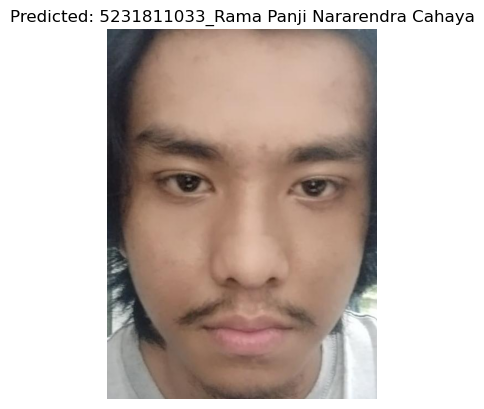

In [91]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- Folder path ---
# img_folder = r"C:\Users\ramap\OneDrive\Documents\Kuliah\data\WhatsApp Image 2025_"
img_folder = r"D:\download_d\data_test"

# --- Helper function: conditional preprocessing ---
def preprocess_image(image_pil, brightness_thresh=0.5):
    """
    Convert to RGB PIL image -> possibly brighten if too dark -> return PIL image.
    """
    # Convert PIL to OpenCV (numpy array)
    img = np.array(image_pil)  # shape H,W,3, RGB
    img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Convert to float [0,1]
    img_float = img_cv.astype(np.float32) / 255.0
    
    # Compute brightness (average luminance)
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray) / 255.0
    
    # If too dark, adjust brightness & contrast
    if brightness < brightness_thresh:
        alpha = 1.2  # contrast
        beta = 0.1   # brightness
        img_float = np.clip(alpha * img_float + beta, 0, 1)
        # Optional gamma correction
        gamma = 1.2
        img_float = np.power(img_float, 1/gamma)
    
    # Convert back to uint8 and PIL
    img_float = (img_float * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_float, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    
    return img_pil

# Get all image files
img_paths = [os.path.join(img_folder, f) 
             for f in os.listdir(img_folder) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Process all images
for img_path in img_paths:
    # Load image
    image = Image.open(img_path).convert("RGB")
    
    # Conditional preprocessing
    image = preprocess_image(image, brightness_thresh=0.5)
    
    # Apply same preprocessing as your train/test set
    img_tensor = test_transform(image).unsqueeze(0).to(device)

    # Extract embedding
    with torch.no_grad():
        embedding = model(img_tensor).cpu().numpy()[0]  # shape (128,)

    # Predict using prototypes
    predicted_cls, sim = predict_embedding(embedding, prototypes, threshold=0.6)  # adjust threshold
    if predicted_cls == -1:
        predicted_name = "Unknown"
    else:
        predicted_name = train_dataset.classes[predicted_cls]

    print(f"Image: {img_path} | Predicted: {predicted_name} | Cosine sim: {sim:.3f}")

    # Display image with label
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_name}")
    plt.show()

In [74]:
cropper = FaceCropper()
cropper.process_folder(r"C:\Users\ramap\OneDrive\Documents\Kuliah\data", r"C:\Users\ramap\OneDrive\Documents\Kuliah\data")

d:\anaconda3\envs\deeplearning\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
d